# <font color='Yellow'> INVISIBLE CLOACKING WITH YOLOV8 SEGMENTATION




<font color='red'>Juan José Valencia Jaramillo


## Librerias y recursos

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import numpy as np
import PIL
import io
import html
import time
import os
import random
import glob
from PIL import Image

### Capturar video de webcam

[colab_webcam.ipynb](https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw#scrollTo=ghUlAJzKSjFT)

Ejecutar código en vídeo de webcam es un poco más complejo que en imágenes. Tenemos que iniciar un flujo de vídeo utilizando nuestra webcam como entrada. A continuación, ejecutamos cada fotograma a través de nuestro programa (detección de rostros) y creamos una imagen superpuesta que contiene el cuadro delimitador de la(s) detección(es). A continuación, superponemos la imagen del cuadro delimitador en el siguiente fotograma de nuestro flujo de vídeo.

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

<font color='orange'> El desarrollo de esta aprox. fue posible gracias a estos dos recursos:



*   [artículo(5)](https://medium.com/@Mert.A/how-to-segment-with-yolov8-f33b1c63b6c6).
*   [diegoperea20
/
invisible-cloak-with-deep-learning](https://github.ufo.k0s.io/diegoperea20/invisible-cloak-with-deep-learning).
* [Segmentación - Ultralytics](https://docs.ultralytics.com/tasks/segment/#models)  



### YOLO segmentation setting up

In [ ]:
!pip install -U ultralytics  # instalar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 kB 14.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [ ]:
import ultralytics  # importar
ultralytics.checks()  # verificar versión, configuración

Ultralytics YOLOv8.2.29 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.0/107.7 GB disk)


In [ ]:
from ultralytics import YOLO    # importar la clase YOLO

if(os.path.exists('/content/yolov8-segment/train/weights/best.pt')):
  model = YOLO('/content/yolov8-segment/train/weights/best.pt')  # cargar el modelo pre-entrenado
else:
  model = YOLO('yolov8m-seg.pt')

100%|██████████| 52.4M/52.4M [00:00<00:00, 77.0MB/s]


### Entrenamiento

[Argumentos](https://docs.ultralytics.com/usage/cfg/#tasks):

* Datos: Ruta al archivo de configuración del conjunto de datos (por ejemplo, coco8.yaml). Este archivo contiene parámetros específicos del conjunto de datos, incluidas las rutas a los datos de entrenamiento y validación, los nombres de las clases y el número de clases.

* epochs: Número total de epochs de entrenamiento. Cada época representa una pasada completa por todo el conjunto de datos. El ajuste de este valor puede afectar a la duración del entrenamiento y al rendimiento del modelo.

* lr0:Tasa de aprendizaje inicial (es decir, SGD=1E-2, Adam=1E-3) . El ajuste de este valor es crucial para el proceso de optimización, ya que influye en la rapidez con la que se actualizan los pesos del modelo.
* weight_decay: Término de regularización L2, que penaliza los pesos grandes para evitar el sobreajuste.
* Paciencia: Número de épocas que hay que esperar sin mejoras en las métricas de validación antes de detener el entrenamiento. Ayuda a prevenir el sobreajuste deteniendo el entrenamiento cuando el rendimiento se estanca.
* Optimizador: Elección del optimizador para el entrenamiento. Las opciones incluyen SGD, Adam, AdamW, NAdam, RAdam, RMSProp, etc., o auto para la selección automática basada en la configuración del modelo. Afecta a la velocidad de convergencia y a la estabilidad.
* batch: Tamaño del lote, con tres modos: establecido como un número entero (por ejemplo, batch=16), modo automático para una utilización del 60% de la memoria de la GPU (batch=-1), o modo automático con una fracción de utilización especificada (batch=0,70).
* imgsz: Tamaño de imagen objetivo para el entrenamiento. Todas las imágenes se redimensionan a esta dimensión antes de introducirlas en el modelo. Afecta a la precisión del modelo y a la complejidad computacional.
* verbose:Habilita la salida verbose durante el entrenamiento, proporcionando registros detallados y actualizaciones de progreso. Útil para depurar y supervisar de cerca el proceso de entrenamiento.
* Guardar: Permite guardar los puntos de control del entrenamiento y los pesos finales del modelo. Útil para reanudar el entrenamiento o el despliegue del modelo.
* Proyecto: Nombre del directorio del proyecto donde se guardan los resultados del entrenamiento. Permite el almacenamiento organizado de diferentes experimentos.


In [ ]:
# Train the model
results = model.train(data="coco8-seg.yaml", epochs=100, lr0=0.01, weight_decay=0.0005, patience=50, optimizer='auto',batch=16, imgsz=640, verbose=True, save=True, project="yolov8-segment")

Ultralytics YOLOv8.2.29 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=coco8-seg.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolov8-segment, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_

100%|██████████| 439k/439k [00:00<00:00, 15.0MB/s]
Unzipping /content/datasets/coco8-seg.zip to /content/datasets/coco8-seg...: 100%|██████████| 25/25 [00:00<00:00, 2566.96file/s]

Dataset download success ✅ (1.0s), saved to /content/datasets



100%|██████████| 755k/755k [00:00<00:00, 25.1MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics.nn.modules.conv.Conv             [384

train: Scanning /content/datasets/coco8-seg/labels/train... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 110.58it/s]

train: New cache created: /content/datasets/coco8-seg/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/coco8-seg/labels/val... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 2635.03it/s]

val: New cache created: /content/datasets/coco8-seg/labels/val.cache


Plotting labels to yolov8-segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to yolov8-segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G     0.8512      2.341      2.749      1.309         25        640: 100%|██████████| 1/1 [00:39<00:00, 39.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:12<00:00, 12.50s/it]

                   all          4         17      0.747       0.95      0.962      0.731      0.682      0.867      0.874      0.617



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G     0.5754      3.001      2.303     0.9934         11        640: 100%|██████████| 1/1 [00:32<00:00, 32.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.65s/it]

                   all          4         17      0.765       0.95      0.962      0.733      0.732      0.916      0.928      0.623



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G     0.6905      1.891      1.786      1.114         27        640: 100%|██████████| 1/1 [00:29<00:00, 29.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.80s/it]

                   all          4         17      0.782       0.95      0.963      0.728      0.744      0.912      0.929      0.623



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G     0.7758      2.488       1.96      1.174         34        640: 100%|██████████| 1/1 [00:30<00:00, 30.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.27s/it]

                   all          4         17      0.791       0.95      0.961      0.727       0.75      0.909      0.929      0.624



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G     0.6115       2.39      1.317      1.034         20        640: 100%|██████████| 1/1 [00:31<00:00, 31.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.51s/it]

                   all          4         17      0.822      0.967      0.976      0.737      0.757      0.905      0.932      0.625



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G     0.7705       2.35      1.531      1.023         31        640: 100%|██████████| 1/1 [00:31<00:00, 31.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.21s/it]

                   all          4         17       0.83      0.967      0.976      0.737       0.76      0.901      0.934      0.625



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G     0.7492      2.277      1.613      1.192         34        640: 100%|██████████| 1/1 [00:30<00:00, 30.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.23s/it]

                   all          4         17      0.841      0.967      0.977      0.738      0.767      0.898      0.936      0.627



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G     0.9602      2.058      2.057      1.349         25        640: 100%|██████████| 1/1 [00:30<00:00, 30.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.26s/it]

                   all          4         17      0.842       0.95      0.977      0.738      0.774      0.877      0.936      0.627



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G     0.7267      1.937      1.337      1.029         39        640: 100%|██████████| 1/1 [00:32<00:00, 32.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.55s/it]

                   all          4         17       0.84      0.946      0.977       0.74      0.787      0.841      0.891      0.623



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G     0.6163      1.556      1.004     0.9978         27        640: 100%|██████████| 1/1 [00:28<00:00, 28.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.36s/it]

                   all          4         17      0.834      0.947      0.977      0.734      0.793      0.827      0.892      0.625



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G     0.4683      1.221     0.8945     0.9776         25        640: 100%|██████████| 1/1 [00:31<00:00, 31.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.43s/it]

                   all          4         17      0.836      0.943      0.977      0.744      0.769       0.89      0.949      0.642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G     0.7362      1.356      1.436       1.22         15        640: 100%|██████████| 1/1 [00:29<00:00, 29.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.37s/it]

                   all          4         17      0.833      0.943      0.975      0.743      0.767      0.878      0.938      0.639



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G     0.6133        2.4      2.116      1.132         18        640: 100%|██████████| 1/1 [00:28<00:00, 28.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.39s/it]

                   all          4         17      0.852      0.934      0.974      0.742      0.753       0.89      0.946      0.658



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G     0.9798       2.86      2.648      1.303         40        640: 100%|██████████| 1/1 [00:29<00:00, 29.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.33s/it]

                   all          4         17       0.86       0.93      0.975      0.745       0.75      0.898      0.947      0.661



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G     0.6449      1.459      1.185      1.095         29        640: 100%|██████████| 1/1 [00:28<00:00, 28.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.11s/it]

                   all          4         17      0.843      0.942      0.972       0.74      0.794      0.844       0.93      0.639



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      0.629      1.289      1.153      1.125         17        640: 100%|██████████| 1/1 [00:31<00:00, 31.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.71s/it]

                   all          4         17      0.835      0.942      0.972       0.74        0.8      0.844       0.93      0.654



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G     0.4009      1.109     0.6468     0.9532         27        640: 100%|██████████| 1/1 [00:29<00:00, 29.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.42s/it]

                   all          4         17      0.832      0.949      0.972      0.739      0.808      0.842      0.922      0.654



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G     0.5226      1.158     0.5541     0.8979         27        640: 100%|██████████| 1/1 [00:28<00:00, 28.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.23s/it]

                   all          4         17      0.832      0.949      0.972      0.739      0.808      0.842      0.922      0.654



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G     0.5441       1.28     0.6002     0.9886         28        640: 100%|██████████| 1/1 [00:29<00:00, 29.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.22s/it]

                   all          4         17      0.831      0.943      0.972      0.736      0.807      0.843      0.907      0.652



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      0.468      1.154     0.4769     0.8976         33        640: 100%|██████████| 1/1 [00:28<00:00, 28.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.54s/it]

                   all          4         17      0.831      0.943      0.972      0.736      0.807      0.843      0.907      0.652



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G     0.5563      1.607     0.5722      1.024         24        640: 100%|██████████| 1/1 [00:28<00:00, 28.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.15s/it]

                   all          4         17      0.828      0.934      0.971      0.732      0.803      0.843      0.898      0.649



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G     0.5422      1.393     0.9407     0.9529         35        640: 100%|██████████| 1/1 [00:28<00:00, 28.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.07s/it]

                   all          4         17      0.828      0.934      0.971      0.732      0.803      0.843      0.898      0.649



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G     0.6681      1.616      1.167      1.093         32        640: 100%|██████████| 1/1 [00:32<00:00, 32.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.58s/it]

                   all          4         17      0.832      0.916      0.971      0.731      0.807      0.844      0.895      0.628



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      0.764      1.293     0.9435      1.153         19        640: 100%|██████████| 1/1 [00:29<00:00, 30.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.92s/it]

                   all          4         17      0.832      0.916      0.971      0.731      0.807      0.844      0.895      0.628



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G     0.2712      1.669      1.049      1.007         11        640: 100%|██████████| 1/1 [00:28<00:00, 28.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.35s/it]

                   all          4         17       0.83      0.916      0.971      0.706       0.79      0.854       0.89      0.629



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G     0.5189      1.306     0.7561     0.9773         28        640: 100%|██████████| 1/1 [00:28<00:00, 28.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.33s/it]

                   all          4         17       0.83      0.916      0.971      0.706       0.79      0.854       0.89      0.629



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G     0.6516       1.63     0.6468      1.139         21        640: 100%|██████████| 1/1 [00:29<00:00, 29.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.29s/it]

                   all          4         17       0.82      0.939      0.971      0.706      0.763      0.882       0.89      0.628



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G     0.6194      1.099     0.6718      1.018         29        640: 100%|██████████| 1/1 [00:29<00:00, 29.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.57s/it]

                   all          4         17       0.82      0.939      0.971      0.706      0.763      0.882       0.89      0.628



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G     0.6574      1.729      1.227      1.139         47        640: 100%|██████████| 1/1 [00:30<00:00, 30.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.42s/it]

                   all          4         17      0.768      0.947       0.97      0.684      0.705      0.883      0.889      0.638



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G     0.3824      1.531     0.8801      1.004          8        640: 100%|██████████| 1/1 [00:28<00:00, 28.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.61s/it]

                   all          4         17      0.768      0.947       0.97      0.684      0.705      0.883      0.889      0.638



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G     0.5472      1.259      0.454     0.9438         29        640: 100%|██████████| 1/1 [00:31<00:00, 31.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.53s/it]

                   all          4         17      0.755      0.948      0.968      0.675       0.69      0.883      0.886      0.629



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G     0.4652      1.266      1.125      1.033         14        640: 100%|██████████| 1/1 [00:28<00:00, 28.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.80s/it]

                   all          4         17      0.755      0.948      0.968      0.675       0.69      0.883      0.886      0.629



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G     0.6334      1.701     0.7913      1.209         19        640: 100%|██████████| 1/1 [00:27<00:00, 27.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.02s/it]

                   all          4         17      0.739      0.952      0.967      0.676       0.67      0.883      0.886      0.626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G     0.4652     0.9402     0.3881     0.9301         29        640: 100%|██████████| 1/1 [00:28<00:00, 28.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.90s/it]

                   all          4         17      0.739      0.952      0.967      0.676       0.67      0.883      0.886      0.626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G     0.5489      1.157     0.6305     0.9592         35        640: 100%|██████████| 1/1 [00:28<00:00, 28.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.14s/it]

                   all          4         17      0.641      0.883       0.94      0.655      0.641      0.883      0.884      0.626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G     0.5636      1.153     0.4224      1.075         25        640: 100%|██████████| 1/1 [00:28<00:00, 28.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.29s/it]

                   all          4         17      0.641      0.883       0.94      0.655      0.641      0.883      0.884      0.626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G     0.5508      0.943     0.4596       1.02         31        640: 100%|██████████| 1/1 [00:28<00:00, 28.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.01s/it]

                   all          4         17       0.67      0.883       0.94      0.668       0.67      0.883      0.884      0.626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G     0.4299     0.9388     0.3634     0.9086         34        640: 100%|██████████| 1/1 [00:29<00:00, 29.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.23s/it]

                   all          4         17       0.67      0.883       0.94      0.668       0.67      0.883      0.884      0.626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G     0.3663      1.024     0.5564     0.9166         31        640: 100%|██████████| 1/1 [00:29<00:00, 29.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.51s/it]

                   all          4         17      0.882      0.634      0.857      0.619      0.882      0.634      0.801      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G     0.4724      1.269     0.4234     0.9392         28        640: 100%|██████████| 1/1 [00:27<00:00, 27.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:12<00:00, 12.00s/it]

                   all          4         17      0.882      0.634      0.857      0.619      0.882      0.634      0.801      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G       0.49      1.141     0.5029     0.9455         35        640: 100%|██████████| 1/1 [00:30<00:00, 30.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.25s/it]

                   all          4         17      0.875      0.637      0.846      0.608      0.875      0.637      0.795      0.527



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G     0.4045     0.9993      0.341     0.8882         24        640: 100%|██████████| 1/1 [00:28<00:00, 28.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.50s/it]

                   all          4         17      0.875      0.637      0.846      0.608      0.875      0.637      0.795      0.527



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G     0.4449      1.085     0.4329     0.9175         24        640: 100%|██████████| 1/1 [00:28<00:00, 28.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.06s/it]

                   all          4         17      0.857      0.636      0.809       0.59      0.857      0.636      0.768      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G     0.6029      1.381     0.8552      1.041         22        640: 100%|██████████| 1/1 [00:28<00:00, 28.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.90s/it]

                   all          4         17      0.857      0.636      0.809       0.59      0.857      0.636      0.768      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G     0.4783      1.149     0.5852      1.005         50        640: 100%|██████████| 1/1 [00:29<00:00, 29.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.80s/it]

                   all          4         17      0.902      0.613      0.805      0.584      0.902      0.613      0.768      0.493



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.4594      0.989     0.4139      0.872         41        640: 100%|██████████| 1/1 [00:31<00:00, 31.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.32s/it]

                   all          4         17      0.902      0.613      0.805      0.584      0.902      0.613      0.768      0.493



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G     0.4874      1.097     0.5768     0.9586         35        640: 100%|██████████| 1/1 [00:28<00:00, 28.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.97s/it]

                   all          4         17      0.907      0.615      0.801      0.583      0.907      0.615      0.773      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.7352      1.438     0.6673      1.096         11        640: 100%|██████████| 1/1 [00:28<00:00, 28.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.99s/it]

                   all          4         17      0.907      0.615      0.801      0.583      0.907      0.615      0.773      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.3832     0.8511     0.3784     0.9623         25        640: 100%|██████████| 1/1 [00:28<00:00, 28.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.81s/it]

                   all          4         17      0.904      0.613      0.796      0.588      0.904      0.613      0.778      0.492



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.4548      1.078     0.3568     0.9808         22        640: 100%|██████████| 1/1 [00:28<00:00, 28.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.90s/it]

                   all          4         17      0.904      0.613      0.796      0.588      0.904      0.613      0.778      0.492



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.4374      1.226     0.3641     0.8633         33        640: 100%|██████████| 1/1 [00:29<00:00, 29.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.26s/it]

                   all          4         17      0.902      0.612       0.79      0.582      0.902      0.612      0.774      0.487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G     0.3699     0.7636     0.3068     0.8894         24        640: 100%|██████████| 1/1 [00:28<00:00, 28.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.34s/it]

                   all          4         17      0.902      0.612       0.79      0.582      0.902      0.612      0.774      0.487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.4863     0.9785     0.4939     0.9424         58        640: 100%|██████████| 1/1 [00:28<00:00, 28.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.68s/it]

                   all          4         17      0.902      0.612       0.79      0.582      0.902      0.612      0.774      0.487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G       0.42      0.812     0.4373     0.9298         25        640: 100%|██████████| 1/1 [00:29<00:00, 29.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.97s/it]

                   all          4         17      0.901       0.61      0.788      0.564      0.901       0.61      0.768      0.488



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G      0.379     0.9488     0.3955      0.897         39        640: 100%|██████████| 1/1 [00:30<00:00, 30.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.56s/it]

                   all          4         17      0.901       0.61      0.788      0.564      0.901       0.61      0.768      0.488



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G     0.2721     0.8381     0.3102     0.8724         15        640: 100%|██████████| 1/1 [00:28<00:00, 28.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.12s/it]

                   all          4         17      0.901       0.61      0.788      0.564      0.901       0.61      0.768      0.488



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G      0.451      1.301     0.6088     0.9651         32        640: 100%|██████████| 1/1 [00:29<00:00, 29.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.62s/it]

                   all          4         17       0.91      0.607      0.783      0.564       0.91      0.607      0.771      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G     0.4662     0.8453     0.4263     0.9616         27        640: 100%|██████████| 1/1 [00:28<00:00, 28.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.29s/it]

                   all          4         17       0.91      0.607      0.783      0.564       0.91      0.607      0.771      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G     0.4126      0.895     0.4642     0.9408         25        640: 100%|██████████| 1/1 [00:28<00:00, 28.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.20s/it]

                   all          4         17       0.91      0.607      0.783      0.564       0.91      0.607      0.771      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G     0.3364     0.8319     0.3081     0.9047         33        640: 100%|██████████| 1/1 [00:29<00:00, 29.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.11s/it]

                   all          4         17      0.906      0.604      0.771      0.558      0.906      0.604      0.771       0.49



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G     0.4384     0.9971      0.333     0.9088         31        640: 100%|██████████| 1/1 [00:28<00:00, 28.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.11s/it]

                   all          4         17      0.906      0.604      0.771      0.558      0.906      0.604      0.771       0.49



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G     0.3574     0.8444     0.3591      1.002         15        640: 100%|██████████| 1/1 [00:28<00:00, 28.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:14<00:00, 14.73s/it]

                   all          4         17      0.906      0.604      0.771      0.558      0.906      0.604      0.771       0.49



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G     0.4082     0.9311     0.4148      0.922         37        640: 100%|██████████| 1/1 [00:28<00:00, 28.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.11s/it]

                   all          4         17      0.909      0.607      0.769       0.56      0.909      0.607      0.769      0.496



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G     0.3546     0.9766     0.4112     0.9165         25        640: 100%|██████████| 1/1 [00:29<00:00, 29.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.07s/it]

                   all          4         17      0.909      0.607      0.769       0.56      0.909      0.607      0.769      0.496
EarlyStopping: Training stopped early as no improvement observed in last 50 epochs. Best results observed at epoch 14, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



64 epochs completed in 0.822 hours.
Optimizer stripped from yolov8-segment/train/weights/last.pt, 54.9MB
Optimizer stripped from yolov8-segment/train/weights/best.pt, 54.9MB

Validating yolov8-segment/train/weights/best.pt...
Ultralytics YOLOv8.2.29 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8m-seg summary (fused): 245 layers, 27268704 parameters, 0 gradients, 110.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.67s/it]


                   all          4         17      0.861       0.93      0.975      0.742      0.781      0.846      0.933      0.657
                person          3         10          1      0.583      0.874      0.566          1      0.575      0.874       0.38
                   dog          1          1      0.877          1      0.995      0.895      0.882          1      0.995      0.995
                 horse          1          2      0.849          1      0.995       0.75      0.852          1      0.995      0.352
              elephant          1          2          1      0.999      0.995      0.449      0.508        0.5      0.745      0.425
              umbrella          1          1      0.708          1      0.995      0.995      0.711          1      0.995      0.995
          potted plant          1          1      0.728          1      0.995      0.796      0.731          1      0.995      0.796
Speed: 3.4ms preprocess, 2354.6ms inference, 0.0ms loss, 2.5ms postpr

#### Exportar salidas del entrenamiento (Cuando se entrena o re entrena)

In [ ]:
from google.colab import files
import shutil

shutil.make_archive("/content/yolov8-segment", 'zip', "/content/yolov8-segment")
files.download("yolov8-segment.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Resultados y métricas

In [ ]:
# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.2.29 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/datasets/coco8-seg/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.06s/it]


                   all          4         17      0.861       0.93      0.975      0.742      0.781      0.846      0.933      0.657
                person          3         10          1      0.583      0.874      0.566          1      0.575      0.874       0.38
                   dog          1          1      0.877          1      0.995      0.895      0.882          1      0.995      0.995
                 horse          1          2      0.849          1      0.995       0.75      0.852          1      0.995      0.352
              elephant          1          2          1      0.999      0.995      0.449      0.508        0.5      0.745      0.425
              umbrella          1          1      0.708          1      0.995      0.995      0.711          1      0.995      0.995
          potted plant          1          1      0.728          1      0.995      0.796      0.731          1      0.995      0.796
Speed: 28.6ms preprocess, 2377.5ms inference, 0.0ms loss, 2.3ms postp

In [ ]:
metrics.box.map  # map50-95(B)

0.7417667725097109

In [ ]:
metrics.seg.map  # map50-95(M)

0.657174732732418

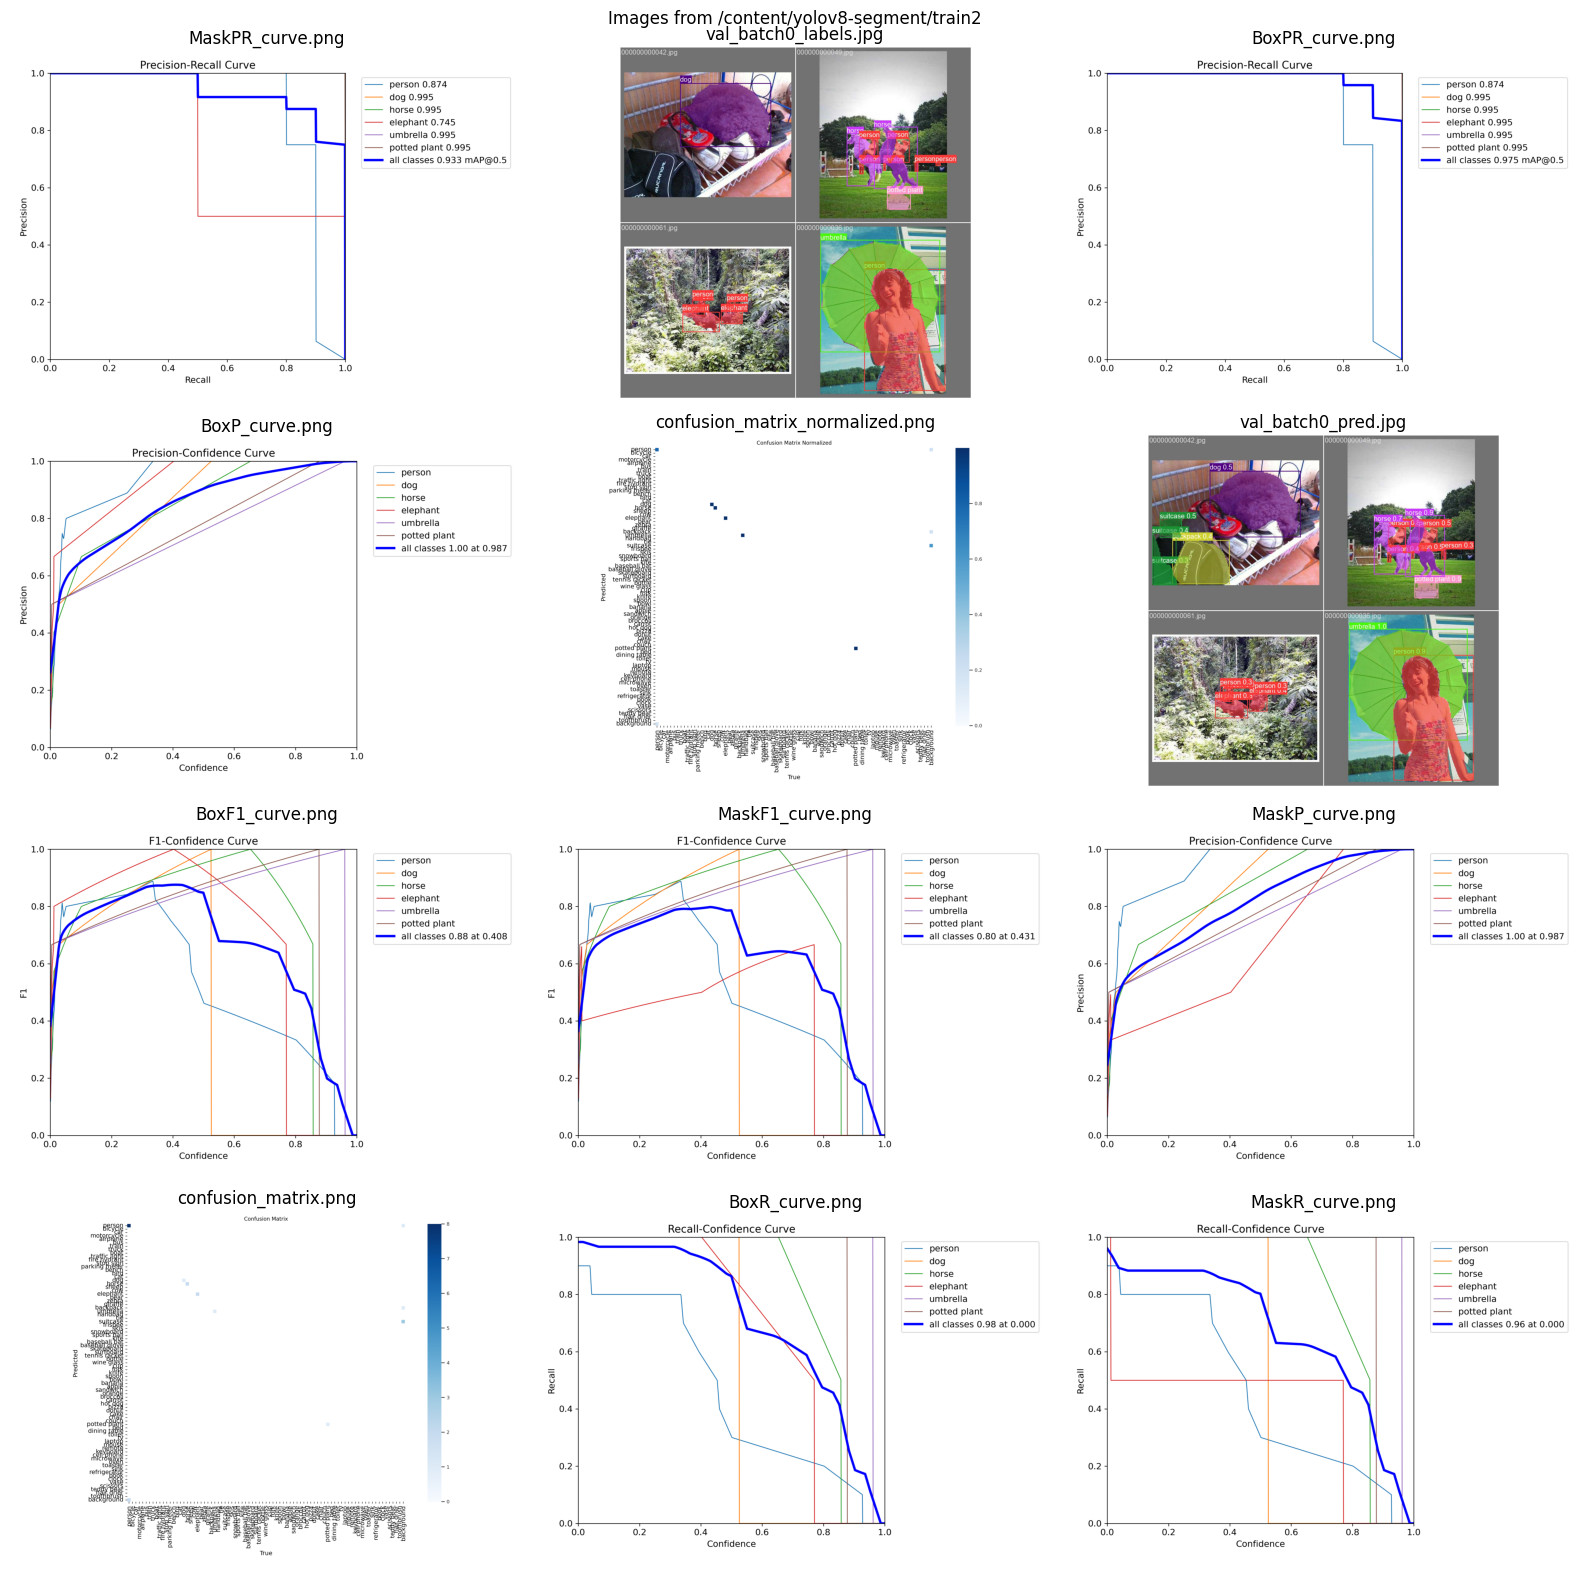

In [ ]:
def plot_images_in_subplots(image_path, rows=4, cols=3, figsize=(16, 16)):
  # Create the figure and subplots
  fig, axes = plt.subplots(rows, cols, figsize=figsize)

  # Flatten the axes for easier iteration
  axes_flat = axes.ravel()

  # Counter for image index
  image_index = 0

  for filename in os.listdir(image_path):
    # Check if it's an image file
    if filename.endswith(".jpg") or filename.endswith(".png"):
      # Load and convert image
      image = Image.open(os.path.join(image_path, filename)).convert("RGB")

      # Check if we've reached the limit of subplots
      if image_index >= rows * cols:
        break

      # Plot the image on the current subplot
      axes_flat[image_index].imshow(image)
      axes_flat[image_index].set_title(filename)
      axes_flat[image_index].axis("off")

      # Increment image index
      image_index += 1

  # Hide unused subplots (optional)
  for ax in axes_flat[image_index:]:
    ax.axis("off")

  # Adjust layout (optional)
  fig.suptitle(f"Images from {image_path}", fontsize=12)
  plt.tight_layout()

  # Show the plot
  plt.show()

# Usage
image_path = "/content/yolov8-segment/train2"  # Replace with your path
plot_images_in_subplots(image_path)

## Demostración de uso

### Abrir la cámara y grabar

<IPython.core.display.Javascript object>


0: 480x640 1 person, 1720.5ms
Speed: 3.3ms preprocess, 1720.5ms inference, 9.7ms postprocess per image at shape (1, 3, 480, 640)


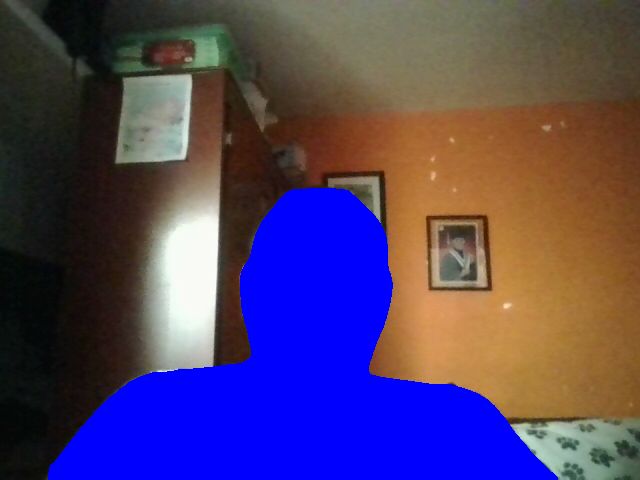


0: 480x640 1 person, 2288.7ms
Speed: 4.0ms preprocess, 2288.7ms inference, 4.9ms postprocess per image at shape (1, 3, 480, 640)


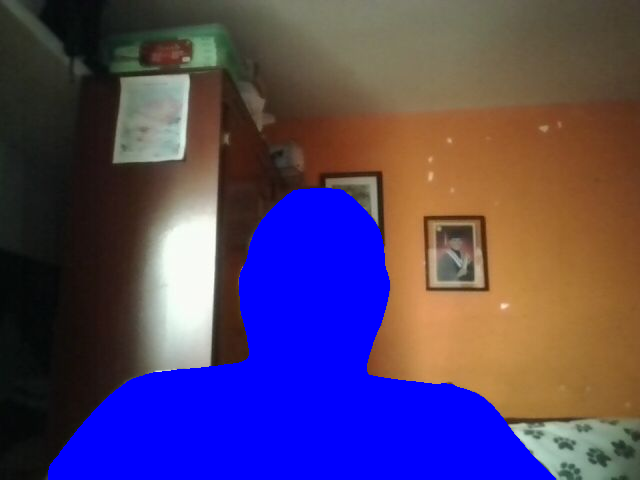

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
bbox = ''

while True:
    js_reply = video_frame(label_html,bbox)
    if not js_reply:
        break
    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # Realizar la detección y segmentación
    resultados = model.predict(frame, imgsz=640, conf=0.78 )

    for result in resultados:
        for mask, box in zip(result.masks.xy, result.boxes):
            points = np.int32([mask])
            cv2.polylines(frame, points, True, (255, 255, 255), 1)
            cv2.fillPoly(frame, points, [255,0,0,0])

    cv2_imshow(frame)
    cv2.waitKey(0)

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
bbox = ''

while True:
    js_reply = video_frame(label_html,bbox)
    if not js_reply:
        break
    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # Realizar la detección y segmentación
    resultados = model.predict(frame, imgsz=640, conf=0.78 )

    for result in resultados:
      for mask, box in zip(result.masks.xy, result.boxes):

        # Create mask with transparency information (alpha channel)
        mask_with_alpha = np.dstack((mask * 255, np.ones_like(mask) * 255))  # White background

        # Extract region of interest (ROI) based on bounding box
        x_min, y_min, x_max, y_max = map(int, box.xyxy[0].cpu().numpy())
        roi = frame[y_min:y_max, x_min:x_max]

        # Apply weighted blending to combine ROI and mask with transparency
        weighted_mask = cv2.addWeighted(roi, 1 - mask, mask_with_alpha, mask, 0)

        # Place the masked ROI back into the original frame
        frame[y_min:y_max, x_min:x_max] = weighted_mask

cv2_imshow(frame)
cv2.waitKey(0)

<IPython.core.display.Javascript object>


0: 480x640 1 person, 2423.5ms
Speed: 3.4ms preprocess, 2423.5ms inference, 7.3ms postprocess per image at shape (1, 3, 480, 640)


error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'addWeighted'
> Overload resolution failed:
>  - Argument 'alpha' can not be treated as a double
>  - Argument 'alpha' can not be treated as a double
